# Imports


In [1]:
import cv2
import torch
torch.cuda.is_available()

True

In [2]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.83 🚀 Python-3.10.11 torch-2.0.0+cu117 CUDA:0 (NVIDIA GeForce GTX 1070, 8114MiB)
Setup complete ✅ (12 CPUs, 15.5 GB RAM, 173.3/467.9 GB disk)


In [3]:
torch.cuda.device_count()

1

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("working on gpu")
else:
    device = torch.device("cpu")
    print("working on cpu")

working on gpu


In [5]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    force_cudnn_initialization()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import time
import os

# Data Proccesing 

In [7]:
# Set the path to the dataset directory
BASEPATH = "../datasets/dog-pose-class/images"
annot_path = "../datasets/dog-pose-class/releases/4/annotations"

In [8]:
# create an empty list to store the results
results = []

# iterate over each file in the directory
for file_name in os.listdir(annot_path):
    if file_name.endswith('.json'):
        # read the JSON file
        with open(os.path.join(annot_path, file_name), 'r') as f:
            json_data = json.load(f)
        try:
            # extract the necessary fields
            file_path = f"{BASEPATH}/{json_data['item']['slots'][0]['source_files'][0]['file_name']}"
            label = json_data['annotations'][0]['name']
            # append the results to the list
            results.append({'Filepath': file_path, 'Label': label})
        except Exception as e:
#             print(f"File name: {file_name} cannot mem loaded.")
            pass

# convert the results list to a dataframe
df = pd.DataFrame(results)

In [9]:
print('Total number of images:', len(df))

Total number of images: 6294


In [10]:
df.head()

Filepath     Label
0  ../datasets/dog-pose-class/images/n02087046_51...  Standing
1  ../datasets/dog-pose-class/images/n02106030_16...      None
2  ../datasets/dog-pose-class/images/n02099712_32...      None
3  ../datasets/dog-pose-class/images/n02089867_18...   Sitting
4  ../datasets/dog-pose-class/images/n02099849_54...   Sitting

In [11]:
# Get the count of each dog breed in the dataset
label_count = pd.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(4))

Dog poses:
Standing    1887
None        1864
Lying       1440
Sitting     1103
Name: Label, dtype: int64


In [12]:
df = df[df['Label'] != 'None']

In [13]:
label_count = pd.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail(4))

Dog poses:
Standing    1887
Lying       1440
Sitting     1103
Name: Label, dtype: int64


## Normalize the amount of data per class

In [14]:
# Get the unique labels and their frequencies
label_counts = df["Label"].value_counts()
unique_labels = label_counts.index.tolist()

# Determine the number of samples to use for each label
num_samples_per_label = label_counts.min()

# Group the data by label
grouped_data = df.groupby("Label")

# Sample a fixed number of samples from each group
sampled_data = pd.DataFrame(columns=["Filepath", "Label"])
for label in unique_labels:
    label_data = grouped_data.get_group(label)
    sampled_indices = np.random.choice(len(label_data), num_samples_per_label, replace=False)
    sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
    
df = sampled_data.reset_index(drop=True)

/tmp/ipykernel_10053/2119700213.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
/tmp/ipykernel_10053/2119700213.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])
/tmp/ipykernel_10053/2119700213.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sampled_data = sampled_data.append(label_data.iloc[sampled_indices])


In [15]:
# Get the count of each dog breed in the dataset
label_count = df.value_counts(df['Label'], ascending=False)
print('Dog poses:')
print(label_count.tail())

Dog poses:
Label
Lying       1103
Sitting     1103
Standing    1103
dtype: int64


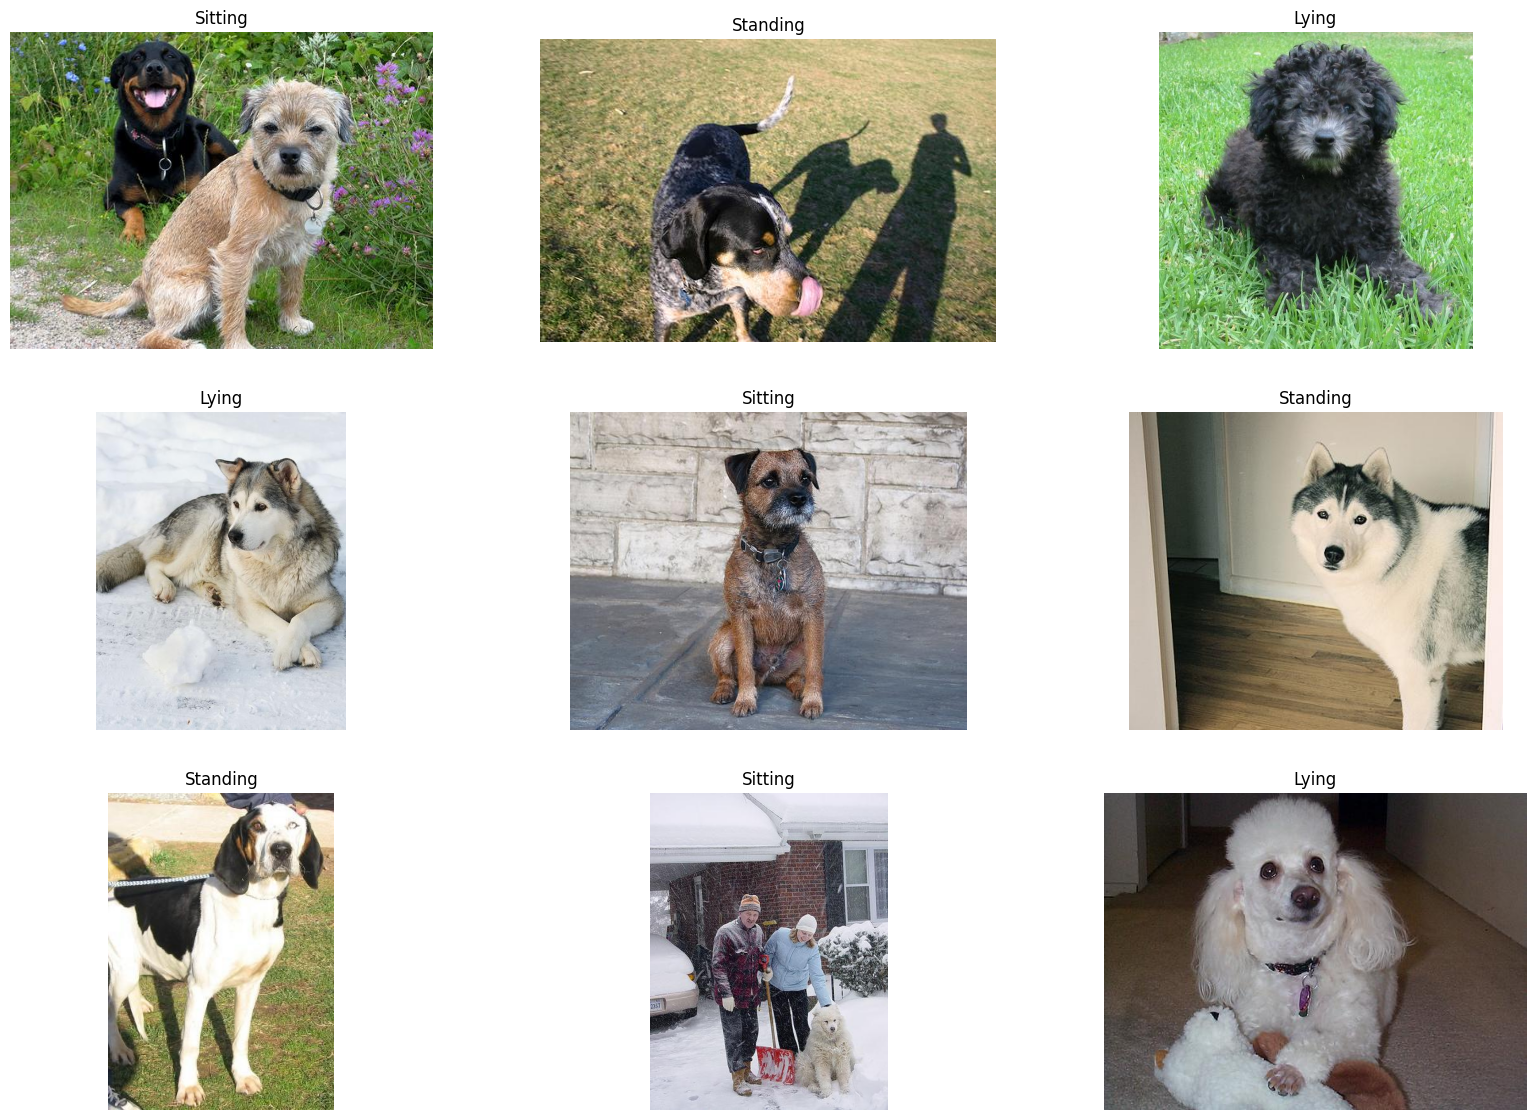

In [16]:
# Randomly select a subset of samples to display
num_samples_to_display = 9
sample_indices = np.random.choice(len(df), num_samples_to_display, replace=False)
sample_df = df.iloc[sample_indices]

# Display the sample images
fig, axis = plt.subplots(num_samples_to_display//3, 3, figsize=(20, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(sample_df.Filepath.iloc[i]))
    ax.set_title(sample_df.Label.iloc[i])
    ax.axis('off')
plt.show()

# Making the data split

In [17]:
# build a test dataframe 
_ , test = train_test_split(df, test_size=0.2)

# Create an ImageDataGenerator object to rescale the test data
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 64
target_size=(224, 224)

# Create a test generator using the test data and the test_datagen object
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col="Filepath",
    y_col="Label",
    batch_size=batch_size,
    shuffle=False,
    target_size=target_size
)


Found 662 validated image filenames belonging to 3 classes.


# Testing

In [18]:
model = load_model('../dnn_model/pose/pose_model.h5')

In [19]:
# Evaluate the model on the test set
loss, acc = model.evaluate(test_generator, steps=test_generator.n // test_generator.batch_size)
print(f"loss on the test set is {loss:.2f}")
print(f"accuracy on the test set is {acc:.3f}")

10/10 [==============================] - 16s 274ms/step - loss: 0.6280 - accuracy: 0.7797
loss on the test set is 0.63
accuracy on the test set is 0.780


In [20]:
# Get the class indices
class_indices = test_generator.class_indices

# Print the class indices in a prettier way
print(json.dumps(class_indices, indent=4))

{
    "Lying": 0,
    "Sitting": 1,
    "Standing": 2
}


In [21]:
# Get the first batch of data from the test generator
x_test, y_test = next(test_generator)

# Use the model to make predictions on the first batch of test data
predictions = model.predict(x_test)


2/2 [==============================] - 8s 23ms/step


In [35]:
x_test.shape

(64, 224, 224, 3)

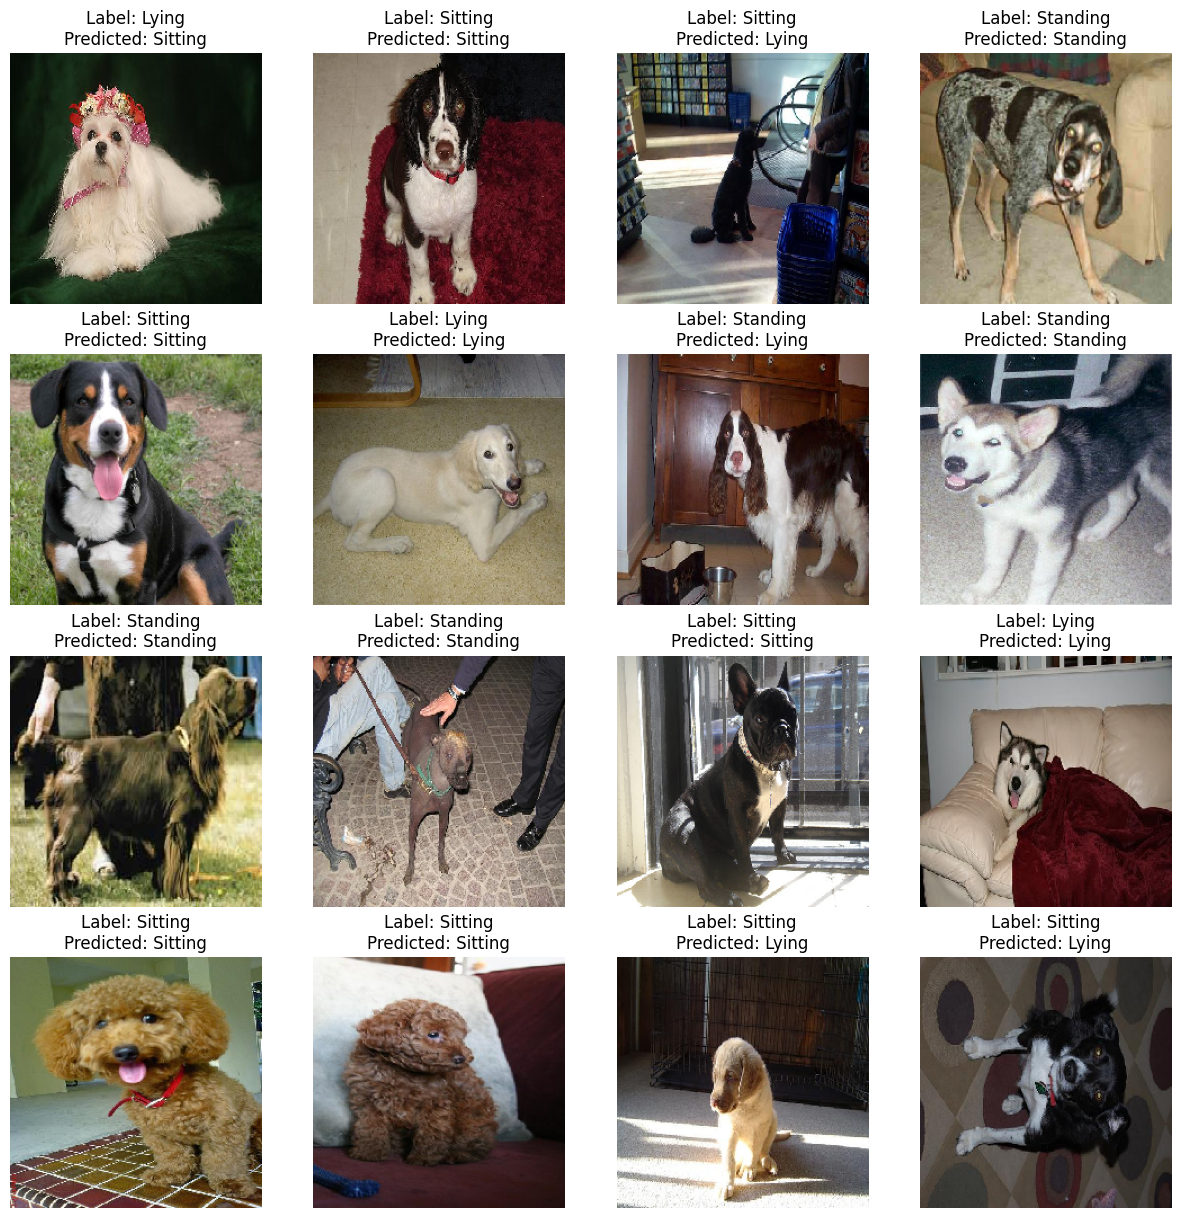

In [36]:
# Visualize the images, labels, and predictions
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15,15))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_test[i])
    # Use a dictionary comprehension to get the keys that correspond to the value
    true_labels = [key for key, value in class_indices.items() if value == y_test[i].argmax()]
    prediction_labels = [key for key, value in class_indices.items() if value == predictions[i].argmax()]

    ax.set_title('Label: {}\nPredicted: {}'.format(true_labels[0], prediction_labels[0]))
    ax.axis('off')

In [23]:
# Make predictions using the test generator
full_predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(full_predictions, axis=1)

# Get the ground truth labels (true_classes) from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Calculate the accuracy score
accuracy = accuracy_score(true_classes, predicted_classes)
print("Test Accuracy:", accuracy)

11/11 [==============================] - 10s 778ms/step
Test Accuracy: 0.7734138972809668


In [24]:
# Calculate the classification report (precision, recall, F1-score, support)
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

       Lying       0.76      0.76      0.76       218
     Sitting       0.73      0.76      0.75       238
    Standing       0.83      0.81      0.82       206

    accuracy                           0.77       662
   macro avg       0.78      0.77      0.78       662
weighted avg       0.77      0.77      0.77       662



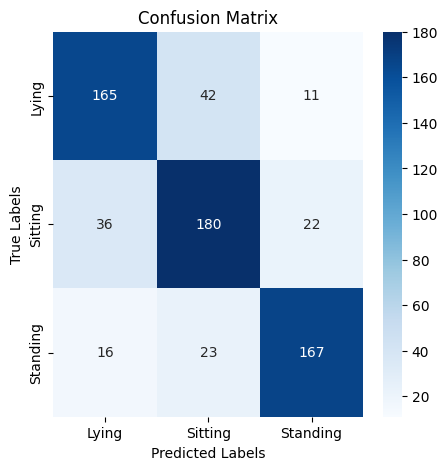

In [25]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

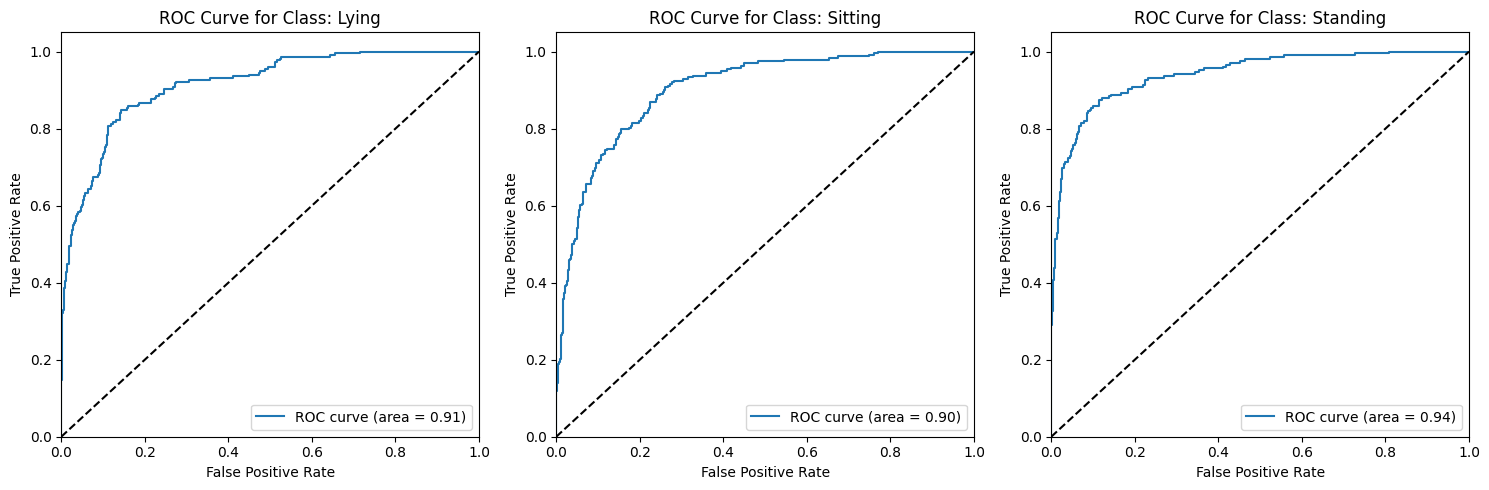

In [26]:
# Get the ground truth labels (true_classes) from the test generator
n_classes = len(test_generator.class_indices)

# Binarize the true_classes to match the shape of the predictions
y_true = label_binarize(true_classes, classes=np.arange(n_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], full_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class in separate subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.ravel()

for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], label='ROC curve (area = {0:0.2f})'.format(roc_auc[i]))
    axes[i].plot([0, 1], [0, 1], 'k--')
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title('ROC Curve for Class: {}'.format(class_labels[i]))
    axes[i].legend(loc="lower right")

# Adjust the layout
fig.tight_layout()
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.cm as cm

In [28]:
# Get the model's predicted probabilities
predictions = model.predict(test_generator, steps=test_generator.n // batch_size)

# Get the true labels
y_true = test_generator.classes


10/10 [==============================] - 3s 261ms/step


In [29]:
# Get the model's predicted probabilities
predictions = model.predict(test_generator, steps=np.ceil(test_generator.n / batch_size))

# Get the true labels
y_true = test_generator.classes

num_classes = predictions.shape[1]


colors = cm.rainbow(np.linspace(0, 1, num_classes))

11/11 [==============================] - 3s 271ms/step


In [30]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, average_precision_score


max_f1 = 0
max_f1_threshold = 0

# This assumes that the precision and recall curves intersect at the point where precision = recall.
# In practice, you might want to compute the average precision at various recall levels and interpolate.
mAP = 0 

max_precision = 0
max_precision_threshold = 0

max_recall = 0
max_recall_threshold = 0

thresholds = np.arange(0.0, 1.0, 0.01)
for class_index in range(num_classes):
    binary_true = (np.array(y_true) == class_index).astype(int)
    
    # Compute average precision for this class and add to mAP
    mAP += average_precision_score(binary_true, predictions[:, class_index])

    for threshold in thresholds:
        binary_predictions = (predictions[:, class_index] > threshold).astype(int)
        
        precision = precision_score(binary_true, binary_predictions)
        recall = recall_score(binary_true, binary_predictions)
        f1 = f1_score(binary_true, binary_predictions)

        if f1 > max_f1:
            max_f1 = f1
            max_f1_threshold = threshold
        
        if precision > max_precision:
            max_precision = precision
            max_precision_threshold = threshold

        if recall > max_recall:
            max_recall = recall
            max_recall_threshold = threshold

mAP /= num_classes  # Take the average across all classes

print(f"F1-confidence curve is: all classes {max_f1:.2f} at {max_f1_threshold:.3f}.")
print(f"Precision-Recall curve is: all classes {mAP:.3f} mAP@0.5.")
print(f"Precision-confidence curve is: all classes {max_precision:.2f} at {max_precision_threshold:.3f}.")
print(f"Recall-confidence curve is: all classes {max_recall:.2f} at {max_recall_threshold:.3f}.")

F1-confidence curve is: all classes 0.83 at 0.350.
Precision-Recall curve is: all classes 0.867 mAP@0.5.
Precision-confidence curve is: all classes 1.00 at 0.950.
Recall-confidence curve is: all classes 1.00 at 0.000.


In [31]:
import scikitplot as skplt
Y_test_pred = model.predict(test_generator, steps=np.ceil(test_generator.n / batch_size))

# Convert predicted probabilities into class labels
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)

# Get the true labels
Y_test = test_generator.classes

11/11 [==============================] - 3s 263ms/step


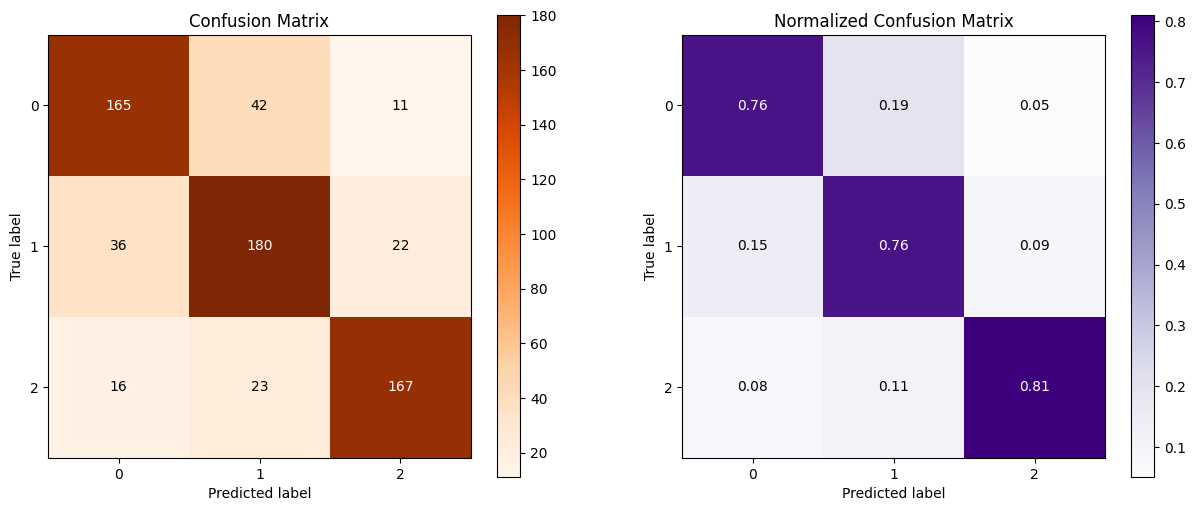

In [32]:
fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(121)
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_pred_classes,
                                    title="Confusion Matrix",
                                    cmap="Oranges",
                                    ax=ax1)

ax2 = fig.add_subplot(122)
skplt.metrics.plot_confusion_matrix(Y_test, Y_test_pred_classes,
                                    normalize=True,
                                    title="Normalized Confusion Matrix",
                                    cmap="Purples",
                                    ax=ax2)

plt.show()

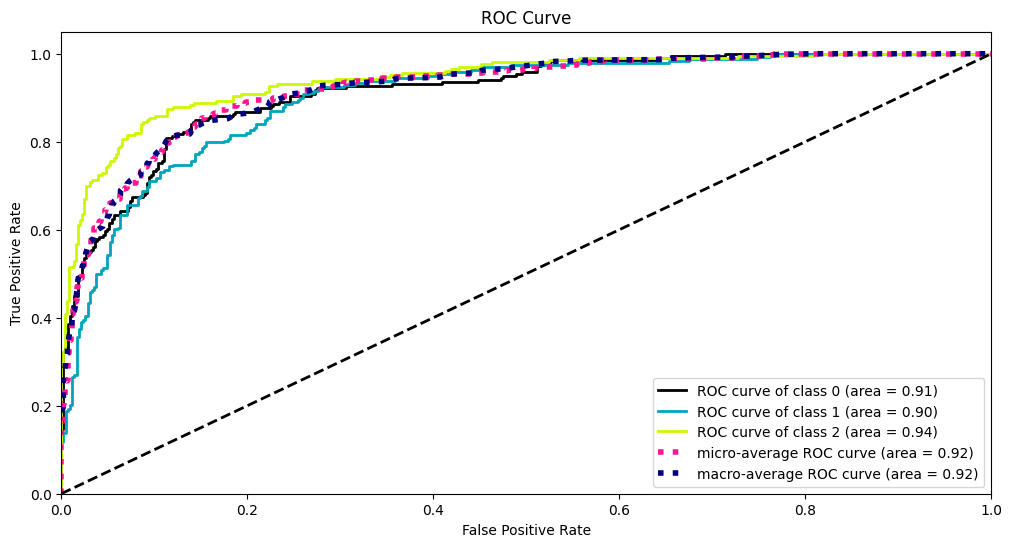

In [33]:
# Plot ROC curve
skplt.metrics.plot_roc(Y_test, Y_test_pred, figsize=(12,6),
                       title='ROC Curve')
plt.legend(loc=('lower right'))
plt.show()

/home/ira-demo/EEfinal_rasp/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=FutureWarning)


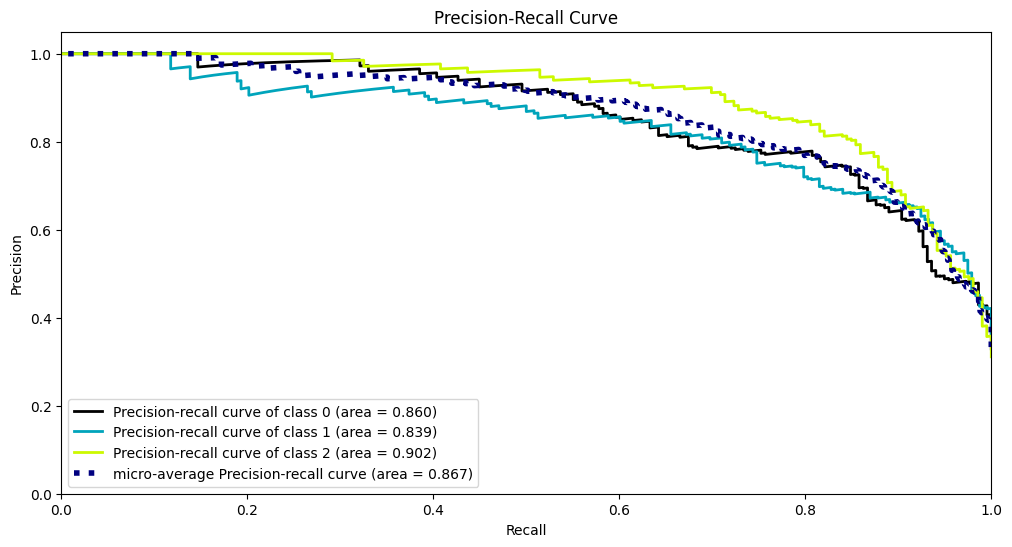

In [34]:
skplt.metrics.plot_precision_recall_curve(Y_test, Y_test_pred,
                       title="Precision-Recall Curve", figsize=(12,6))
plt.legend(loc=('lower left'))
plt.show()